In [1]:
import utils.cs_vqe_tools as c_tools
import utils.qonversion_tools as qonvert
import utils.bit_tools as bit
import utils.circuit_tools as circ
import utils.linalg_tools as la
import utils.plotting_tools as plot
import legacy.eigenstate_generator as eig_old

import cs_vqe_classes.cs_vqe as c
import cs_vqe_classes.eigenstate as eig
import cs_vqe_classes.cs_vqe_circuit as cs_circ

import ast
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from openfermion.linalg import LinearQubitOperator, get_sparse_operator, get_ground_state
import itertools
from statistics import median, mean

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [55]:
f = open("hamiltonians/hamiltonians.txt","r")
hamiltonians = ast.literal_eval(f.read())
f.close()

small_ham_keys = []

for h in hamiltonians.keys():
    num_qubits = hamiltonians[h][1]
    if num_qubits < 10:
        small_ham_keys.append(h)

small_ham_keys

['Be1_STO-3G_singlet',
 'H1-F1_STO-3G_singlet',
 'H1-Li1_STO-3G_singlet',
 'H1-O1_STO-3G_singlet',
 'H2-Be1_STO-3G_singlet',
 'H2_3-21G_singlet',
 'H2_6-31G_singlet',
 'Ne1_STO-3G_singlet',
 'H1-He1_STO-3G_singlet',
 'H3_STO-3G_singlet_1+',
 'H1-He1_3-21G_singlet_1+',
 'H3_3-21G_singlet_1+']

In [90]:
shots=5
nc_mols={}

for speciesname in small_ham_keys:
    num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
    hamiltonian = hamiltonians[speciesname][2] # full Hamiltonian
    terms_noncon = list(hamiltonians[speciesname][3].keys()) # noncontextual part of Hamiltonian, found by greedy DFS
    mol = c.cs_vqe(hamiltonian, terms_noncon, num_qubits)
    initial_state = mol.init_state()
    G = mol.generators()[0]
    A = mol.generators()[1]
    eig_proj = la.eigenstate_projector(A, num_qubits)
    results = {}
    nan_check = []
    for index in range(num_qubits):
        removed_index = list(range(0, index))
        removed_index.reverse()
        removed_generators = [list(G.keys())[i] for i in removed_index]
        Z_indices = [g.find('Z') for g in removed_generators]
        print(removed_generators, Z_indices)
        nc_proj = la.noncon_projector(initial_state, Z_indices, num_qubits)

        new_ham_noncon, new_ham_context = mol.move_generator(removed_generators)
        new_ham_noncon_q = qonvert.dict_to_QubitOperator(new_ham_noncon)
        new_ham_context_q = qonvert.dict_to_QubitOperator(new_ham_context)
        
        results[index] = {}

        results[index]['exact'] = get_ground_state(get_sparse_operator(new_ham_noncon_q, num_qubits).toarray())[0]

        expectations = []
        for r in range(shots):
            #expect_noncon, expect_context = eig.expectation_optimiser(molecule=molecule, ham_n=new_ham_noncon_q, ham_c=new_ham_context_q, 
            #                                                          r1=r1, r2=r2, amps=amps, initial_state=initial_state,num_qubits=num_qubits,
            #                                                          Z_indices=Z_indices,rot=True)
            rand_vec = la.random_complex_vector(2**num_qubits)
            psi = la.apply_projections(rand_vec, [nc_proj, eig_proj])
            expect_noncon = la.expectation(new_ham_noncon_q, psi, num_qubits)
            print(expect_noncon)
            expectations.append(expect_noncon)
            nc_value = (sum(expectations)/shots).real
        
        results[index]['+1eig'] = nc_value
        nan_check.append(nc_value)
    
    if all([not np.isnan(n) for n in nan_check]):
        nc_mols[speciesname] = results
        nc_mols[speciesname]['num_qubits'] = num_qubits

nc_mols

[] []
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
['ZIIII'] [0]


/mnt/c/Users/Tim/Jupyter Projects/ContextualSubspaceVQE/utils/linalg_tools.py:100: RuntimeWarning: invalid value encountered in true_divide
  print(psi)


(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
['IZIII', 'ZIIII'] [1, 0]
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
['IIZII', 'IZIII', 'ZIIII'] [2, 1, 0]
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
['IIIIZ', 'IIZII', 'IZIII', 'ZIIII'] [4, 2, 1, 0]
(-10.915236622890802+0j)
(-10.915236622890804+5.551115123125783e-17j)
(-10.915236622890806-5.551115123125783e-17j)
(-10.915236622890806+0j)
(-10.9152366228908+0j)
[] []
(-103.5574515288342-4.263256414560601e-14j)
(-103.55745152883411-1.4210854715202004e-14j)
(-103.55745152883398-6.661338147750939e-16j)
(-103.55745152883412-2.842170943040401e-14j)
(-103.55745152883406-5.684341886080802e-14j)
['ZIIIIIII'] [0]
(-102.9183947599094+3.552713678800501e-14j)
(-102.91839475990933-1.7763568394002505e-15j)
(-102.91839475990935+3.552713678800501e-15j)
(-102.91839475990935-1.4210854715202004e-14j)
(-102.91839475990939-1.4210854715202004e-14j)
['IZIIIIII', 'ZIIIIIII'] [1, 0]
(-101.09343070449398+2.1316282072803006e-14j)
(-101

KeyboardInterrupt: 

In [73]:
nc_mols.pop('Ne1_STO-3G_singlet')

{0: {'exact': -126.60452499680483, '+1eig': -126.60452499680483},
 1: {'exact': -121.44961238741676, '+1eig': -121.44951927689613},
 2: {'exact': -119.36847036412931, '+1eig': -119.36838329057787},
 3: {'exact': -115.39499315281554, '+1eig': -115.3948353746884},
 4: {'exact': -96.7393749935239, '+1eig': -96.73886727708623},
 'num_qubits': 5}

(2, 5)


Text(0.5, 0.98, 'Noncontextual ground state energy - restriction to +1-eigenspace versus exact')

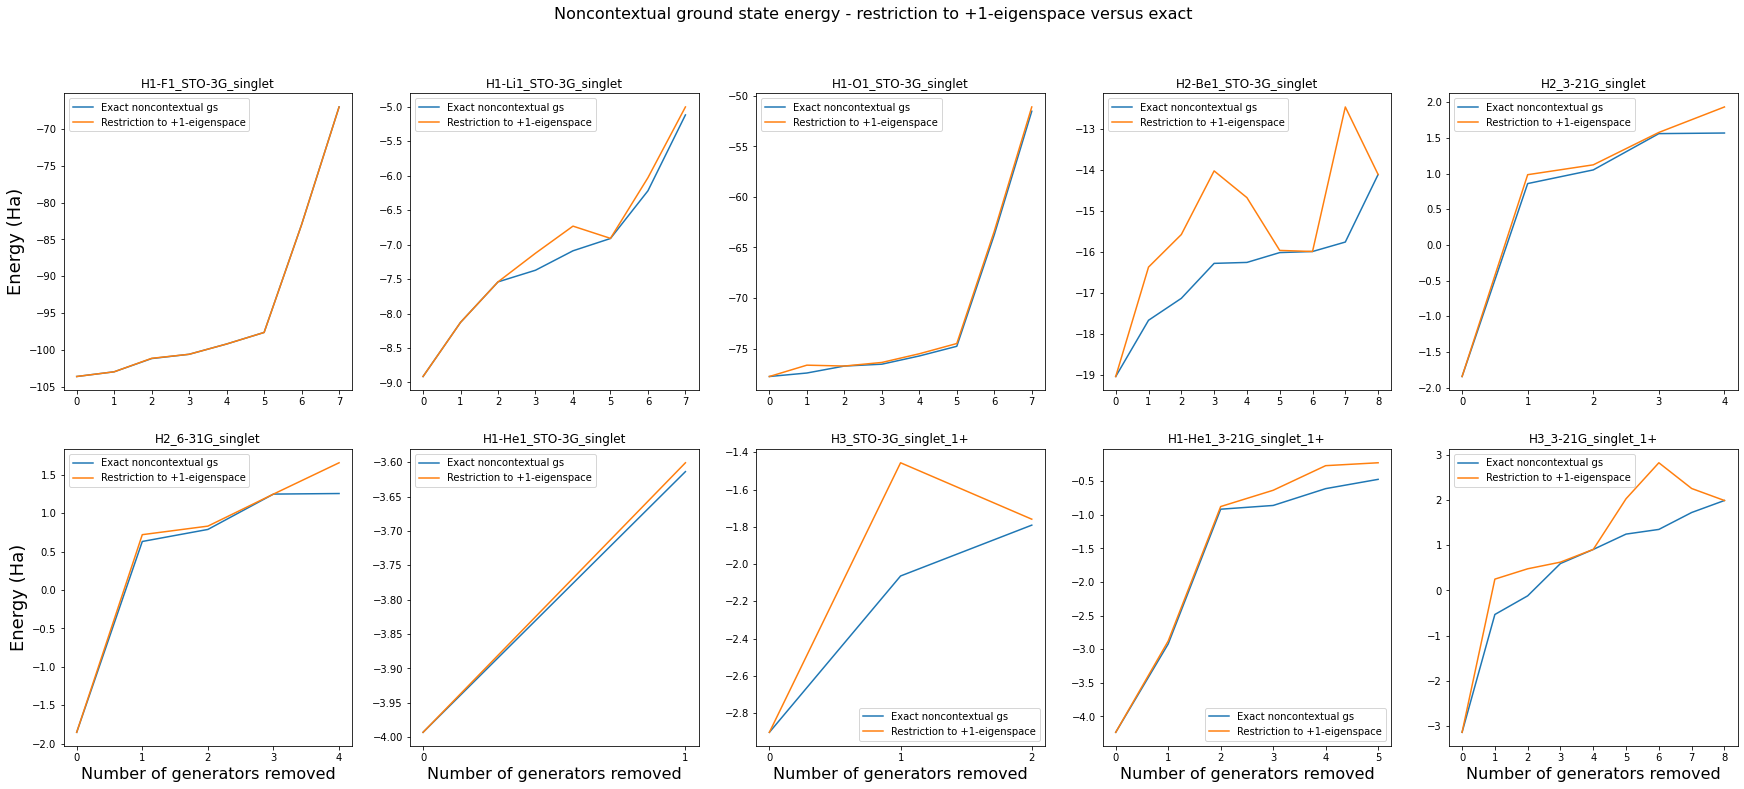

In [86]:
factors = la.factor_int(len(nc_mols))
print(factors)
if factors[0] == 1:
    grid_pos = range(factors[1])
else:
    grid_pos = list(itertools.product(range(factors[0]), range(factors[1])))

fig, axs = plt.subplots(nrows = factors[0], ncols = factors[1], figsize = (6*factors[1],6*factors[0]))

for index, h in enumerate(nc_mols.keys()):
    grid = grid_pos[index]
    
    num_qubits = nc_mols[h]['num_qubits']
    X=range(num_qubits)
    values = list(zip(*[list(nc_mols[h][i].values()) for i in X]))
    Y1=values[0]
    Y2=values[1]
    axs[grid].set_title(str(h))
    axs[grid].plot(X, Y1, label='Exact noncontextual gs')
    axs[grid].plot(X, Y2, label='Restriction to +1-eigenspace')
    axs[grid].set_xticks(X)
    axs[grid].legend()
    
    if factors[0] != 1:
        if grid[0] == 1:
            axs[grid].set_xlabel('Number of generators removed',fontsize=16)
        if grid[1] == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    else:
        axs[grid].set_xlabel('Number of generators removed',fontsize=16)
        if grid == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)

    
fig.suptitle('Noncontextual ground state energy - restriction to +1-eigenspace versus exact', fontsize=16)

In [87]:
fig.savefig("plots/nc_+1_restriction_versus_exact", dpi=300)

In [53]:
grid_pos

range(0, 5)

In [89]:
A

{'IIXZZZZZ': 2.0113630944690537e-07, 'IIZIIIII': -0.9999999999999798}